# Л.р. №7: Нейронные сети

In [242]:
%matplotlib inline
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [167]:
from mnist import MNIST
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import scale

## Часть 1. Предобработка и визуализация данных

In [332]:
def transform_image(img):
    return np.reshape(img, (784, 1))

def transform_label(j, n=10):
    e = np.zeros((n, 1))
    e[j] = 1.0
    return e

In [333]:
%%time

mnist_loader = MNIST("data/")

train_images, train_labels = mnist_loader.load_training()
test_images, test_labels = mnist_loader.load_testing()

train_images = np.array(list(map(transform_image, train_images)))
test_images  = np.array(list(map(transform_image, test_images)))
train_labels = np.array(list(map(transform_label, train_labels)))
test_labels  = np.array(list(map(transform_label, test_labels)))

CPU times: user 7.5 s, sys: 213 ms, total: 7.72 s
Wall time: 7.72 s


In [337]:
def binarize_images(imgs):
    return (imgs > 120).astype(int)

def standartize_images(imgs):
    return scale(imgs, axis=1)

train_images = binarize_images(train_images)
test_images = binarize_images(test_images)

Визуализируем случайные 10 элементов обучающей, и затем тестовой выборки:

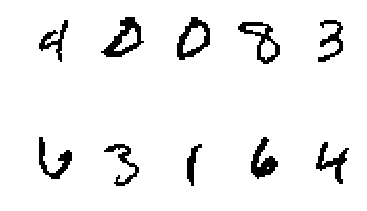

In [338]:
np.random.seed(42)

train_indices = np.random.randint(0, len(train_images), 10)

for ix, image in enumerate(train_images[train_indices]):
    plt.subplot(2, 5, ix + 1)
    plt.axis("off")
    plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

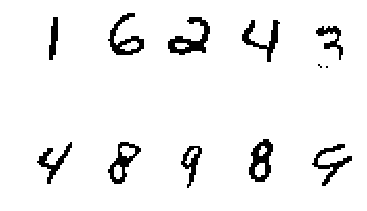

In [339]:
np.random.seed(42)

test_indices = np.random.randint(0, len(test_images), 10)

for ix, image in enumerate(test_images[test_indices]):
    plt.subplot(2, 5, ix + 1)
    plt.axis("off")
    plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

## Часть 2. NN Classifier

In [396]:
# Cost functions

class QuadraticCost(object):
    @staticmethod
    def fn(a, y):
        return 0.5 * np.linalg.norm(a - y) ** 2

    @staticmethod
    def delta(z, a, y):
        return (a - y) * Dσ(z)

class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y * np.log(a) - (1 - y) * np.log(1 - a)))

    @staticmethod
    def delta(z, a, y):
        return a - y

In [398]:
# Sigmoid ctivation function

def σ(x):
    return 1.0 / (1.0 + np.exp(-x))

def Dσ(x):
    return σ(x) * (1 - σ(x))

In [445]:
class NNClassifier(object):
    def __init__(self, sizes, cost=CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost

    def default_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, X):
        for b, w in zip(self.biases, self.weights):
            X = σ(np.dot(w, X) + b)
        return X

    def SGD(self, train_data, epochs, mini_batch_size, eta):
        n = len(train_data)
        for j in range(epochs):
            random.shuffle(train_data)
            mini_batches = [
                train_data[k : k + mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            accuracy = self.accuracy(train_data) / n
            print("epoch=%d: accuracy=%.3f" % (j, accuracy))

    def update_mini_batch(self, mini_batch, eta):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_grad_b, delta_grad_w = self.backprop(x, y)
            grad_b = [nb + dnb for nb, dnb in zip(grad_b, delta_grad_b)]
            grad_w = [nw + dnw for nw, dnw in zip(grad_w, delta_grad_w)]
        self.weights = [w - (eta / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, grad_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb
                       for b, nb in zip(self.biases, grad_b)]

    def backprop(self, x, y):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        # Forward propagation of weights
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = σ(z)
            activations.append(activation)
        # Backward propagation of weights
        δ = (self.cost).delta(zs[-1], activations[-1], y)
        grad_b[-1] = δ
        grad_w[-1] = np.dot(δ, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            dσ = Dσ(z)
            δ = np.dot(self.weights[-l+1].transpose(), δ) * dσ
            grad_b[-l] = δ
            grad_w[-l] = np.dot(δ, activations[-l-1].transpose())
        return (grad_b, grad_w)

    def accuracy(self, data, convert=False):
        results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                   for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

## Часть 3. Обучение классификатора

In [449]:
%%time

train_data = list(zip(train_images, train_labels))

clf = NNClassifier([784, 300, 10])
clf.SGD(train_data, 20, 64, 0.1)

epoch=0: accuracy=0.881
epoch=1: accuracy=0.896
epoch=2: accuracy=0.909
epoch=3: accuracy=0.918
epoch=4: accuracy=0.922
epoch=5: accuracy=0.928
epoch=6: accuracy=0.933
epoch=7: accuracy=0.939
epoch=8: accuracy=0.941
epoch=9: accuracy=0.946
epoch=10: accuracy=0.948
epoch=11: accuracy=0.951
epoch=12: accuracy=0.954
epoch=13: accuracy=0.956
epoch=14: accuracy=0.959
epoch=15: accuracy=0.960
epoch=16: accuracy=0.963
epoch=17: accuracy=0.964
epoch=18: accuracy=0.967
epoch=19: accuracy=0.968
CPU times: user 3h 6min 20s, sys: 33.4 s, total: 3h 6min 54s
Wall time: 50min 15s


## Часть 4. Использование и оценка классификатора

In [450]:
%%time

# Compute predictions
y_true = np.argmax(test_labels, axis=1).T[0]
y_pred = np.array([np.argmax(clf.feedforward(x)) for x in test_images])

CPU times: user 3.72 s, sys: 17 ms, total: 3.74 s
Wall time: 982 ms


### Частота ошибок на контрольной выборке

In [451]:
score = accuracy_score(y_true, y_pred)
print("Error rate: %.1f%%" % (100 * (1 - score)))

Error rate: 3.8%


### Confusion Matrix

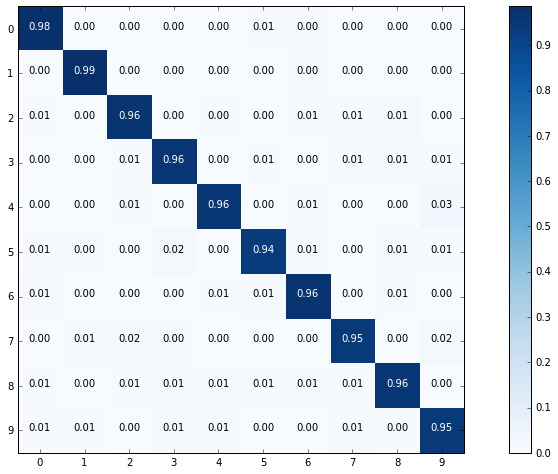

In [452]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(16, 8))
plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.colorbar()
classes = range(10)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid("off")

# Plot digits of confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "%.2f" % cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")


plt.show()

### Анализ ошибок классификатора

In [453]:
wrong_ones = []
for d in range(10):
    wrong_ones.append([])

for i, (true, pred) in enumerate(zip(y_true, y_pred)):
    if true != pred:
        img = test_images[i]
        wrong_ones[true].append((img, pred, i))

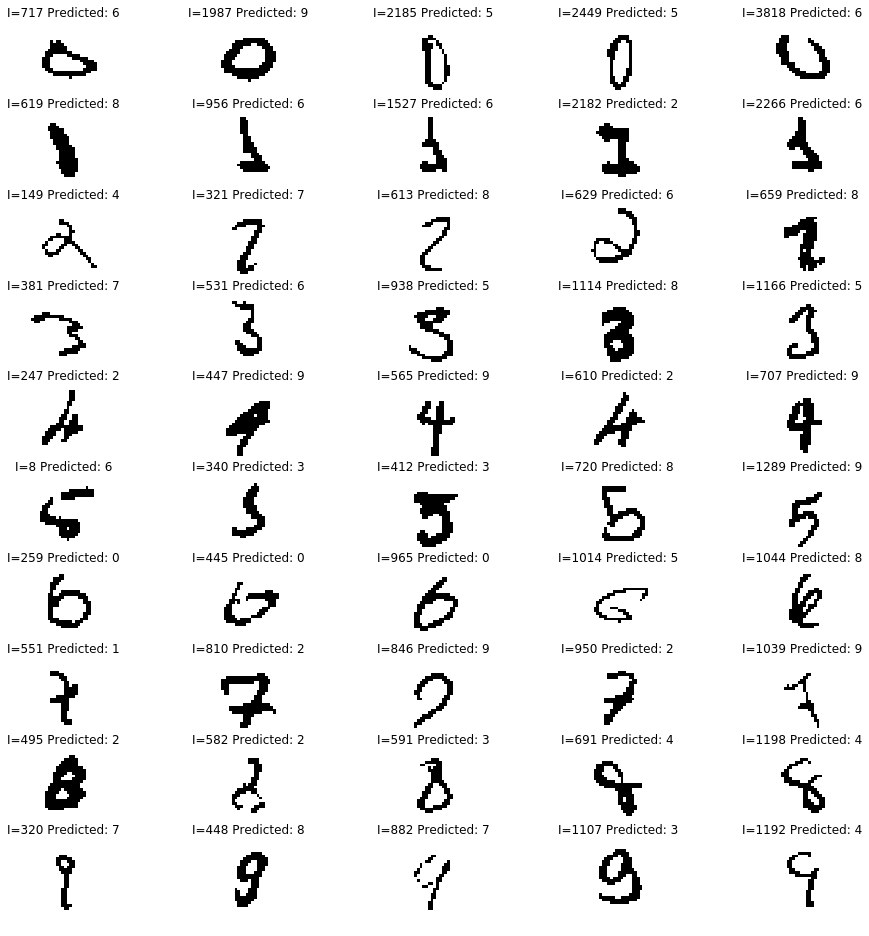

In [454]:
topN = 5

plt.figure(figsize=(16, 16))
for d in range(10):
    for k, (img, pred, i) in enumerate(wrong_ones[d][:topN]):
        plt.subplot(10, topN, topN * d + k + 1)
        plt.axis("off")
        plt.imshow(np.reshape(img, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
        plt.title("I=%d Predicted: %d" % (i, pred))
plt.show()

### Дообучение на тестовой выборке

In [465]:
indices_to_learn = [320, 448, 882, 1107, 1192]

In [466]:
%%time

additional_train_data = list(zip(test_images[indices_to_learn], test_labels[indices_to_learn]))

clf.update_mini_batch(additional_train_data, 0.1)

CPU times: user 47 ms, sys: 1e+03 µs, total: 48 ms
Wall time: 15 ms


### Ручное распознавание тестовой выборки

In [468]:
indices_to_test = [320, 448, 882, 1107, 1192]

In [469]:
y_additional_pred = np.array([np.argmax(clf.feedforward(x)) for x in test_images[indices_to_test]])

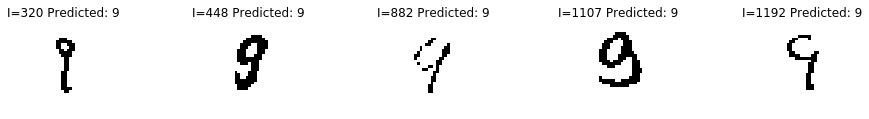

In [470]:
plt.figure(figsize=(16, 16))
for k, (pred, i) in enumerate(zip(y_additional_pred, indices_to_test)):
    img = test_images[i]
    plt.subplot(10, len(indices_to_test), len(indices_to_test) * d + k + 1)
    plt.axis("off")
    plt.imshow(np.reshape(img, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title("I=%d Predicted: %d" % (i, pred))
plt.show()

### Ручное распознавание изображений

In [471]:
from PIL import Image

In [531]:
FILENAME = "2.png"

In [532]:
pil_image = Image.open("data/manual/" + FILENAME).resize((28, 28))
img = (255 - np.asarray(pil_image.convert("L"))).reshape(784, 1)

In [533]:
img = binarize_images(img)

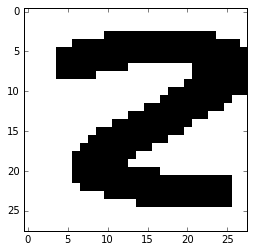

In [534]:
plt.imshow(np.reshape(img, (28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")

In [535]:
y_additional_pred = np.argmax(clf.feedforward(img))
print("Predicted value: %d" % y_additional_pred)

Predicted value: 2


---

**Источники:**

* *К. В. Воронцов, «Математические методы обучения по прецедентам», глава «Искусственные нейронные сети» (http://machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)*
* *Michael Nielsen, «Neural networks and deep learning», Chapter 3 «Improving the way neural networks learn» (http://neuralnetworksanddeeplearning.com/chap3.html)*